In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)

In [18]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.YlOrRd.copy()
cmap_show_empty.set_bad(color='black')

In [19]:
seed(10)

In [20]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel

        self.values = np.random.rand(n, n) # uniformly distribute the house values between 0 and 1
        choices = np.array([0, 1], dtype = np.int8)
        self.array = np.random.choice(2, (n, n), p = [self.prob_empty, 1 - self.prob_empty]) # randomly choosing which houses are empty, with probability prob_empty

        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values[2:-2,2:-2], self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array[2:-2,2:-2], self.kernel, boundary='wrap', mode='same')

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total,number)

        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values, cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam*self.average_neighbors() + grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [21]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        #self.affluences = np.random.rand(n,n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        # self.prob_rich = (1 - self.prob_emp)/3
        # self.prob_middle= (1 - self.prob_emp)/3
        # self.prob_poor = (1 - self.prob_emp)/3
        self.size = n
        # limiting this to just two, the zeros here give us empty houses, but I'm not sure this is really necessary since we just swap people's houses anyway.
        # use the numpy routine choice to select the different cells with probability
        #self.array = np.random.choice(choices, (n, n), p = probs)
        # self.array = np.multiply(self.array,grid_houses.array)
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.choice(choices, (n, n), p = probs)
        self.affluences = np.multiply(self.affluences,grid_houses.array)

    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)
        #print(i1,j1,i2,j2)
        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    # print("t1 = ",t1)
                    # print("t2 = ",t2)
                    # print("swapped agents")
                    # print(f"i1: {i1}, j1: {j1} \n i2: {i2}, j2: {j2}")
                    # print("First ",self.affluences[i1][j1])
                    # print("Second ",self.affluences[i2][j2])
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        for i1 in range(self.array.shape[1]):
            for j1 in range(self.array.shape[0]):
                for i2 in range(self.array.shape[1]):
                    for j2 in range(self.array.shape[0]):
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                # print("House 1: ",grid_houses.values[i1][j1])
                                # print("House 2: ",grid_houses.values[i2][j2])
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                print("t1 =",t1)
                                print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [22]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 0, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

In [23]:
grid_houses1 = grid_houses(9,.1, kernel)
grid_agents1 = grid_agents(9, 0.1, grid_houses1)

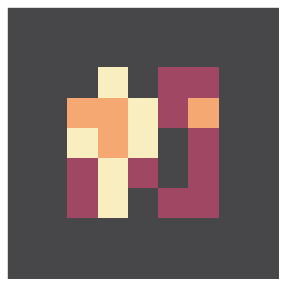

In [24]:
grid_agents1.draw_affluences()

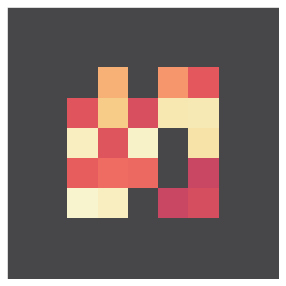

In [25]:
grid_houses1.draw_values()

## Running the code (100,000 times)

In [26]:
grid_houses1.update_values(grid_agents1,.001)
grid_agents1.swap_people(grid_houses1)

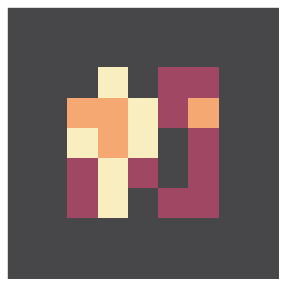

In [27]:
grid_houses1.draw_values()

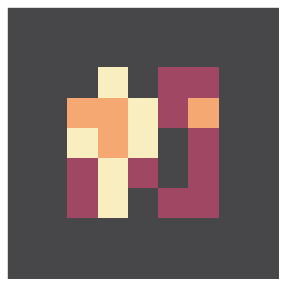

In [28]:
grid_agents1.draw_affluences()

The poorer are going to the edges, due to how we defined our averaging function (boundary = 'fill'), so this probably needs to be changed.

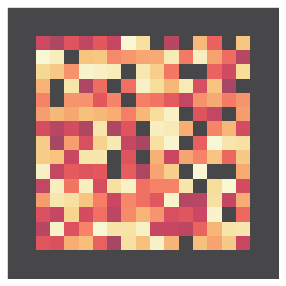

In [29]:
grid_houses1 = grid_houses(19,.1, kernel)
grid_agents1 = grid_agents(19, 0.1, grid_houses1)
grid_houses1.draw_values()

In [30]:
swap_exists = grid_agents1.swap_exists(grid_houses1)
lam = 0.5
i =0

t1 = 0.7901862884540325
t2 = 0.8648095265392068
t1 = 1.0480545200927172
t2 = 1.0480545200927172
t1 = 0.5920406592528782
t2 = 0.6589477963928079
t1 = 0.6432096880523108
t2 = 0.4448273173522884


In [31]:
print(swap_exists)

True


In [32]:
while swap_exists:
    grid_houses1.update_values(grid_agents1,lam)
    grid_agents1.swap_people(grid_houses1)
    swap_exists = grid_agents1.swap_exists(grid_houses1)
    print(swap_exists)
    i += 1
    print(i)

t1 = 0.13321979709600346
t2 = 0.44711220828859854
t1 = 0.1277522756689997
t2 = 0.1277522756689997
t1 = 0.12572615715452684
t2 = 1.7046403517035507
t1 = 0.11889782029487556
t2 = 1.671286688143982
t1 = 0.10234414408505979
t2 = 1.5817139473179358
t1 = 0.10828459180351421
t2 = 1.615572217731399
t1 = 0.11694888898450254
t2 = 1.6614410476713517
t1 = 0.11707732344893573
t2 = 0.40375172044436064
t1 = 0.14840412501084393
t2 = 0.48492699126792366
t1 = 0.13780507370507064
t2 = 0.45878789134632486
t1 = 0.14022818941940057
t2 = 1.7706569138378097
t1 = 0.15602984853676283
t2 = 1.8369439323097052
t1 = 0.14436975156948723
t2 = 0.14436975156948723
t1 = 0.14574178220279213
t2 = 1.7943654586161455
t1 = 0.13642272349658155
t2 = 0.4552933604630392
t1 = 0.12063834414393734
t2 = 1.679951163273532
t1 = 0.1098187968799584
t2 = 0.38277502436111527
t1 = 0.11024462864561937
t2 = 0.11024462864561937
t1 = 0.1005073243806149
t2 = 0.3539505840011281
t1 = 0.10640679962737531
t2 = 1.6051102532251371
t1 = 0.117240519739